# Imports + pipeline call

In [29]:
import importlib
import matplotlib.pyplot as plt
import pandas as pd

from constants import taxi_constants
from pipelines import taxi_pipeline
from viz_taxi import plot_rides_date, plot_passenger_counts, plot_geo_distr, plot_trips_month, \
  plot_trip_day, plot_trip_hour

importlib.reload(taxi_constants)
importlib.reload(taxi_pipeline)

ImportError: cannot import name 'plot_trips_month' from 'viz_taxi' (/Users/Wendo99/Documents/50-Apps/PyCharm/NYC_Taxi/src/viz_taxi.py)

In [2]:
taxi = pd.read_csv('../data/raw/train.csv')

# EDA Hist / describe

- 1458644 rows
- 11 columns
- object: id, pickup_datetime, dropoff_datetime, store_and_fwd_flag
- int64: vendor_id, passenger_count, trip_duration
- float64: pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
- no missing values/categories
- no NaNs
- id can be used for unique ID
- two unique vendors seems to be all right
- ten unique passengers
- two unique store_and_fwd_flag matches with description
- no duplicated rows

In [3]:
taxi.describe(include='object')

,id,pickup_datetime,dropoff_datetime,store_and_fwd_flag
count,1458644,1458644,1458644,1458644
unique,1458644,1380222,1380377,2
top,id2875421,2016-03-04 08:07:34,2016-02-19 19:25:04,N
freq,1,5,5,1450599


## vendor_id

In [4]:
taxi['vendor_id'].value_counts()

vendor_id
2    780302
1    678342
Name: count, dtype: int64

In [5]:
taxi['vendor_id'].isna().sum()

0

- Only two unique values: 1 and 2.
- Frequencies are relatively balanced.
- No missing values or anomalies detected.

##  pickup_datetime & dropoff_datetime

In [6]:
print("Missing pickup_datetime:", taxi['pickup_datetime'].isna().sum())
print("Missing dropoff_datetime:", taxi['dropoff_datetime'].isna().sum())

Missing pickup_datetime: 0
Missing dropoff_datetime: 0


In [7]:
invalid_times = (taxi['dropoff_datetime'] < taxi['pickup_datetime'])
print("Trips with negative duration:", invalid_times.sum())

Trips with negative duration: 0


- no negative durations

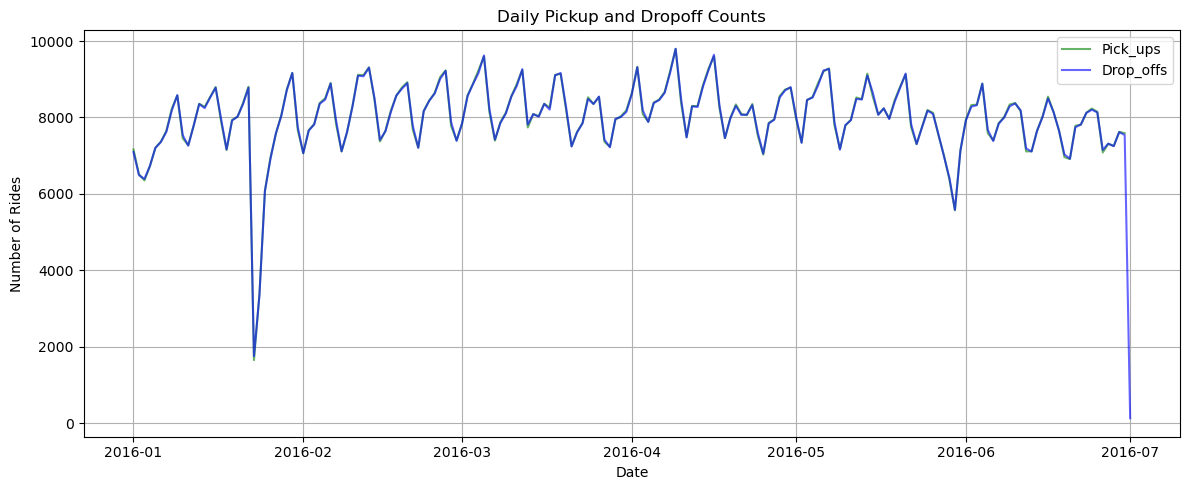

In [8]:
taxi['pickup_datetime'] = pd.to_datetime(taxi['pickup_datetime'], errors='coerce')
taxi['dropoff_datetime'] = pd.to_datetime(taxi['dropoff_datetime'], errors='coerce')

pickup_counts = taxi['pickup_datetime'].dt.date.value_counts().sort_index()
dropoff_counts = taxi['dropoff_datetime'].dt.date.value_counts().sort_index()

plot_rides_date(pickup_counts, dropoff_counts)

- aligns with expected rush hour effects

##  passenger_count

In [9]:
print(taxi['passenger_count'].value_counts().sort_index())

passenger_count
0         60
1    1033540
2     210318
3      59896
4      28404
5      78088
6      48333
7          3
8          1
9          1
Name: count, dtype: int64


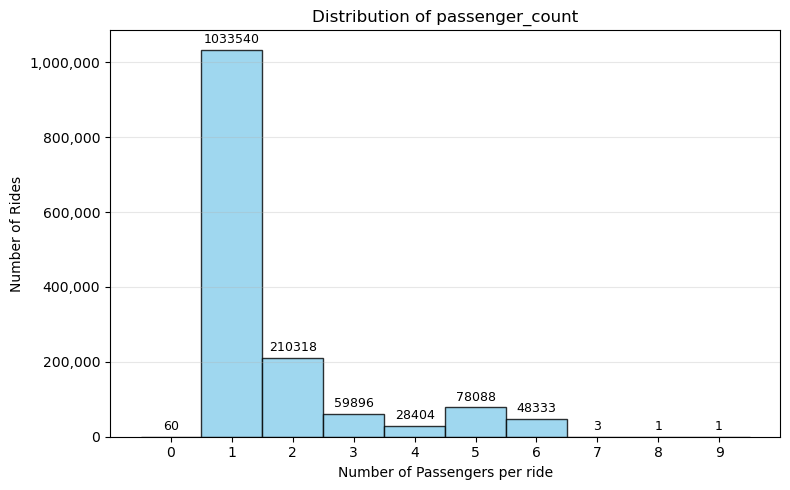

In [10]:
pc = taxi['passenger_count'].dropna().astype(int)

plot_passenger_counts(pc)

- 60 with passenger count 0
- 5 with passenger count > 6

<Axes: xlabel='passenger_count'>

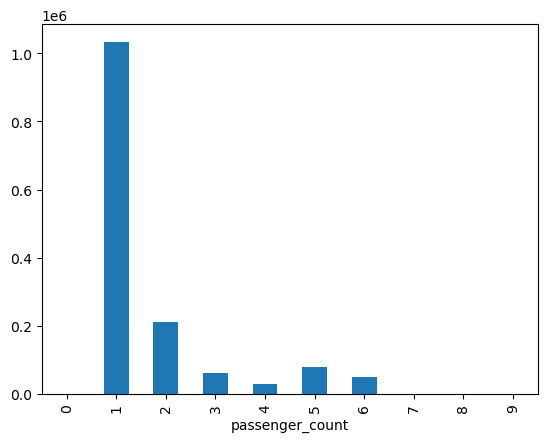

In [11]:
taxi['passenger_count'].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='passenger_count'>

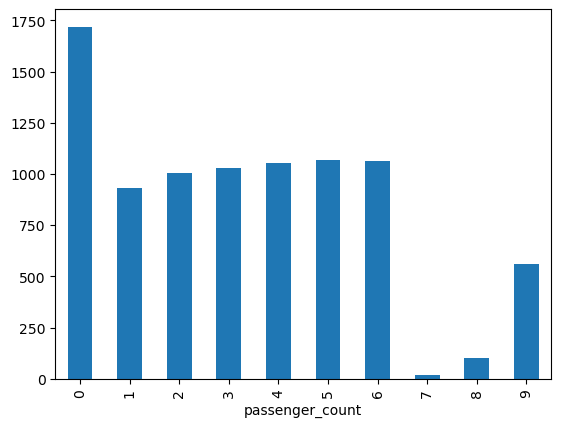

In [12]:
taxi.groupby('passenger_count')['trip_duration'].mean().plot(kind='bar')

- Passenger count = 0 has the highest average trip duration, which is not plausible, indicating likely data entry or logging errors

- Passenger count = 1 dominates at all hours
- Group trips (2–4 passengers) are more frequent in the evening and late night

##  pickup_longitude, pickup_latitude & dropoff_longitude, dropoff_latitude

- Some trip coordinates lie outside NYC bounds
- Some points lie far outside the visible city bounds — likely due to GPS glitches or data corruption.

## Geographic distribution

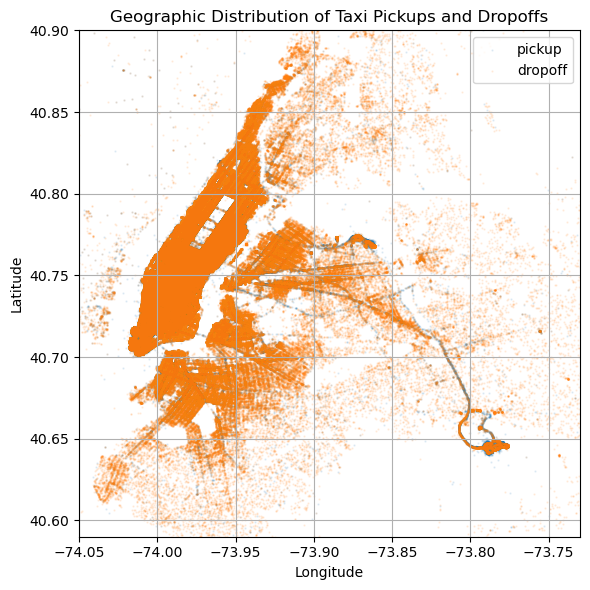

In [13]:
plot_geo_distr(taxi['pickup_longitude'], taxi['pickup_latitude'], taxi['dropoff_longitude'], taxi['dropoff_latitude'])

- Most pickups and dropoffs are located within the NYC area (Manhattan, Brooklyn, Queens).
- Clear density clusters appear around Midtown and Downtown Manhattan.

##  store_and_fwd_flag

In [14]:
print(taxi['store_and_fwd_flag'].value_counts(dropna=False))

store_and_fwd_flag
N    1450599
Y       8045
Name: count, dtype: int64


- store_and_fwd_flag = 'Y' is rare and likely not predictive on its own

##  trip_duration

In [28]:
plot_trips_month(taxi)

TypeError: plot_trips_month() takes 0 positional arguments but 1 was given

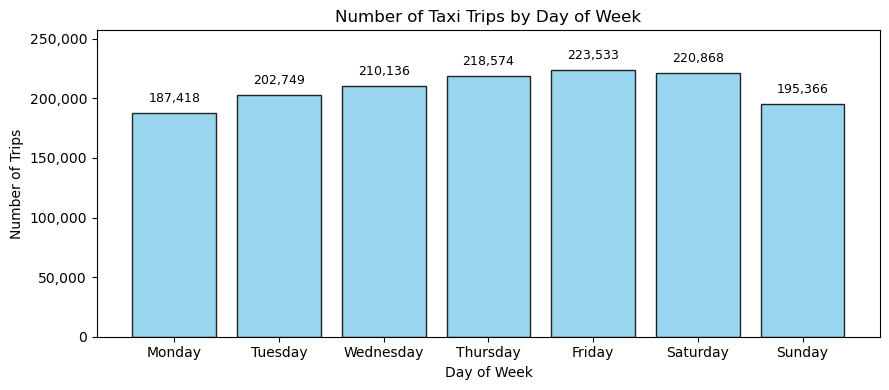

In [26]:
taxi['pickup_datetime'] = pd.to_datetime(taxi['pickup_datetime'], errors='coerce')


plot_trip_day(taxi)

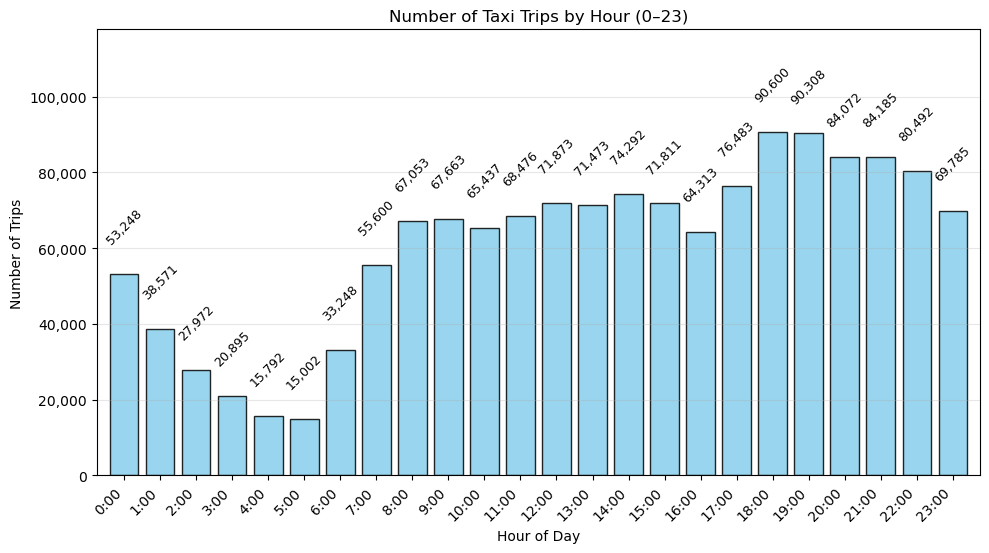

In [18]:
taxi['pickup_datetime'] = pd.to_datetime(taxi['pickup_datetime'], errors='coerce')

plot_trip_hour(taxi)

In [ ]:
taxi['trip_duration'].describe()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(taxi['trip_duration'], bins=100, range=(0, 3600),
        color='skyblue', edgecolor='black', alpha=0.8, label='trip_duration')
ax.set_xlim(left=0)
ax.set_xlabel("Duration (seconds)")
ax.set_ylabel("Number of Rides")
ax.set_title("Trip Duration Distribution (0–3600 s)")
ax.legend(loc='upper right')
ax.grid(True)
plt.tight_layout()
plt.show()

- Several trips have a duration longer than 2 hours, which is highly unlikely for intra-city NYC taxi rides. A few trips are also shorter than 1 minute, which may indicate errors or missing data.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(taxi['trip_duration_log'], bins=100,
        color='skyblue', edgecolor='black', alpha=0.8, label='trip_duration')
ax.set_title("Trip Duration Distribution - Log-Transformed")
ax.set_xlabel("log(1 + trip_duration [s])")
ax.set_ylabel("Number of Rides")
ax.legend(loc='upper right')
ax.grid(True)
plt.tight_layout()
plt.show()

## distance feature (Haversine)

In [ ]:
taxi.plot.scatter(x='hav_dist_km', y='trip_duration', alpha=0.3)

In [ ]:
filtered_data = taxi[
  (taxi['hav_dist_km'] <= 60) &
  (taxi['hav_dist_km'] > 0.0) &
  (taxi['trip_duration'] <= 3600) &
  (taxi['trip_duration'] > 0)
  ]

plt.figure(figsize=(10, 5))
plt.scatter(filtered_data['hav_dist_km'], filtered_data['trip_duration'], alpha=0.1, s=1)
plt.xlabel("hav_dist_km")
plt.ylabel("Trip Duration (min)")
plt.title("Trip Duration vs. hav_dist_km (Filtered: ≤20 km & ≤60 min)")
plt.grid(True)
plt.tight_layout()
plt.show()

- Long durations at very short distances
- Long distances with short durations